<a href="https://colab.research.google.com/github/nithya251006/project1/blob/main/NITHYA_P(24BDS138).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✔ Dataset Loaded Successfully!

   duration protocol_type service  flag  src_bytes  dst_bytes  land  \
0      1418          icmp  domain  RSTO      80905      53459     1   
1       954           tcp     ssh    SH      89571      38402     0   
2       983          icmp     ssh    S0       1589      57727     0   
3       974           tcp     ssh   REJ      25235      38578     0   
4      4133          icmp  telnet    SF        159      90453     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               3       3    4  ...                 253   
1               0       3    6  ...                 180   
2               3       1    9  ...                 220   
3               1       2    6  ...                  86   
4               1       2    3  ...                  96   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                0.095768                0.253454   
1                0.160345                0.356366   
2                0.085467  

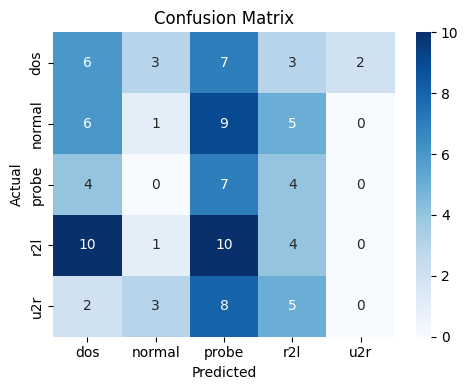

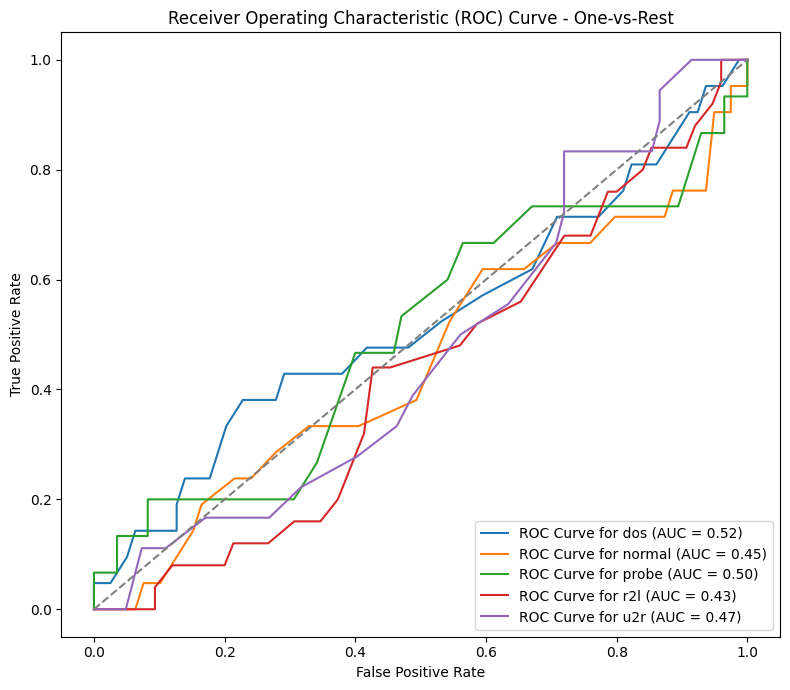

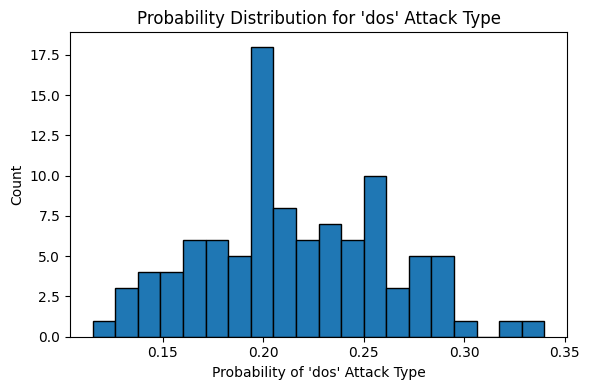


=== SAMPLE PREDICTION ===
Predicted Attack Type : dos
Class Probabilities:
  dos: 0.2400
  normal: 0.1550
  probe: 0.2250
  r2l: 0.1500
  u2r: 0.2300

=== SAMPLE PREDICTION ===
Predicted Attack Type : dos
Class Probabilities:
  dos: 0.2400
  normal: 0.1550
  probe: 0.2250
  r2l: 0.1500
  u2r: 0.2300


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, roc_curve, auc
)

df = pd.read_csv("/content/sample_data/synthetic_nsl_kdd.csv", encoding='latin1')

print("✔ Dataset Loaded Successfully!\n")
print(df.head())

# The 'fraud' column was not found. Please identify the correct target variable.
# X = df.drop("fraud", axis=1)
# y = df["fraud"]

print("Available columns in df:")
print(df.columns)

# Once you identify the correct target column, you can uncomment and adjust these lines:
# X = df.drop("YOUR_TARGET_COLUMN", axis=1)
# y = df["YOUR_TARGET_COLUMN"]

# numeric_cols = X.select_dtypes(include=['int64','float64']).columns
# categorical_cols = X.select_dtypes(include=['object']).columns

# Assuming 'DEALSIZE' is the target variable for classification.
# Please adjust 'DEALSIZE' to your actual target column if it's different.
X = df.drop("attack", axis=1)
y = df["attack"]

numeric_cols = X.select_dtypes(include=['int64','float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("classifier", RandomForestClassifier(n_estimators=200, random_state=42))
])


x_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(x_train, y_train)
print("\n✔ Model Training Completed!")

y_pred = model.predict(X_test)
y_prob_multiclass = model.predict_proba(X_test)

print("\n============= MODEL PERFORMANCE ============")
print("Accuracy  :", accuracy_score(y_test, y_pred))
print("Precision :", precision_score(y_test, y_pred, average='weighted'))
print("Recall    :", recall_score(y_test, y_pred, average='weighted'))
print("ROC-AUC   :", roc_auc_score(y_test, y_prob_multiclass, multi_class='ovr', average='weighted'))
print("==============================================\n")

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

from sklearn.preprocessing import LabelBinarizer

# Get the unique classes from the fitted model, which determines the order of probabilities
classes = model.classes_

plt.figure(figsize=(8, 7))

# Plot ROC curve for each class using One-vs-Rest approach
for i, class_name in enumerate(classes):
    # Binarize the true labels for the current class (1 if it's the class, 0 otherwise)
    y_test_binarized = (y_test == class_name).astype(int)

    # Get the predicted probabilities for the current class from the multiclass probability array
    y_score = y_prob_multiclass[:, i]

    fpr, tpr, _ = roc_curve(y_test_binarized, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"ROC Curve for {class_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve - One-vs-Rest")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Assuming you want to plot the probability distribution for one of the classes, e.g., 'Small'
# You can change 'Small' to 'Medium' or 'Large' as needed.

# Get the index of the 'Small' class from the model's classes
# The current dataset does not have 'Small', 'Medium', 'Large' classes. Instead, it has attack types.
# Let's pick the first class for demonstration.
if len(model.classes_) > 0:
    first_class_name = model.classes_[0]
    first_class_idx = 0

    plt.figure(figsize=(6,4))
    plt.hist(y_prob_multiclass[:, first_class_idx], bins=20, edgecolor="black")
    plt.title(f"Probability Distribution for '{first_class_name}' Attack Type")
    plt.xlabel(f"Probability of '{first_class_name}' Attack Type")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

sample_data = {
    'duration': 0,
    'protocol_type': 'tcp',
    'service': 'http',
    'flag': 'SF',
    'src_bytes': 0,
    'dst_bytes': 0,
    'land': 0,
    'wrong_fragment': 0,
    'urgent': 0,
    'hot': 0,
    'num_failed_logins': 0,
    'logged_in': 1,
    'num_compromised': 0,
    'root_shell': 0,
    'su_attempted': 0,
    'num_root': 0,
    'num_file_creations': 0,
    'num_shells': 0,
    'num_access_files': 0,
    'num_outbound_cmds': 0,
    'is_host_login': 0,
    'is_guest_login': 0,
    'count': 1,
    'srv_count': 1,
    'serror_rate': 0.0,
    'srv_serror_rate': 0.0,
    'rerror_rate': 0.0,
    'srv_rerror_rate': 0.0,
    'same_srv_rate': 1.0,
    'diff_srv_rate': 0.0,
    'srv_diff_host_rate': 0.0,
    'dst_host_count': 255,
    'dst_host_srv_count': 255,
    'dst_host_same_srv_rate': 1.0,
    'dst_host_diff_srv_rate': 0.0,
    'dst_host_same_src_port_rate': 0.0,
    'dst_host_srv_diff_host_rate': 0.0,
    'dst_host_serror_rate': 0.0,
    'dst_host_srv_serror_rate': 0.0,
    'dst_host_rerror_rate': 0.0,
    'dst_host_srv_rerror_rate': 0.0
}
sample = pd.DataFrame([sample_data])

pred = model.predict(sample)[0]
probabilities = model.predict_proba(sample)[0] # Get all probabilities for the single sample

print("\n=== SAMPLE PREDICTION ===")
print("Predicted Attack Type :", pred)
print("Class Probabilities:")
for i, class_name in enumerate(model.classes_):
    print(f"  {class_name}: {probabilities[i]:.4f}")

sample_data = {
    'duration': 0,
    'protocol_type': 'tcp',
    'service': 'http',
    'flag': 'SF',
    'src_bytes': 0,
    'dst_bytes': 0,
    'land': 0,
    'wrong_fragment': 0,
    'urgent': 0,
    'hot': 0,
    'num_failed_logins': 0,
    'logged_in': 1,
    'num_compromised': 0,
    'root_shell': 0,
    'su_attempted': 0,
    'num_root': 0,
    'num_file_creations': 0,
    'num_shells': 0,
    'num_access_files': 0,
    'num_outbound_cmds': 0,
    'is_host_login': 0,
    'is_guest_login': 0,
    'count': 1,
    'srv_count': 1,
    'serror_rate': 0.0,
    'srv_serror_rate': 0.0,
    'rerror_rate': 0.0,
    'srv_rerror_rate': 0.0,
    'same_srv_rate': 1.0,
    'diff_srv_rate': 0.0,
    'srv_diff_host_rate': 0.0,
    'dst_host_count': 255,
    'dst_host_srv_count': 255,
    'dst_host_same_srv_rate': 1.0,
    'dst_host_diff_srv_rate': 0.0,
    'dst_host_same_src_port_rate': 0.0,
    'dst_host_srv_diff_host_rate': 0.0,
    'dst_host_serror_rate': 0.0,
    'dst_host_srv_serror_rate': 0.0,
    'dst_host_rerror_rate': 0.0,
    'dst_host_srv_rerror_rate': 0.0
}
sample = pd.DataFrame([sample_data])

pred = model.predict(sample)[0]
probabilities = model.predict_proba(sample)[0] # Get all probabilities for the single sample

print("\n=== SAMPLE PREDICTION ===")
print("Predicted Attack Type :", pred)
print("Class Probabilities:")
for i, class_name in enumerate(model.classes_):
    print(f"  {class_name}: {probabilities[i]:.4f}")